## Prediktiv Analyse


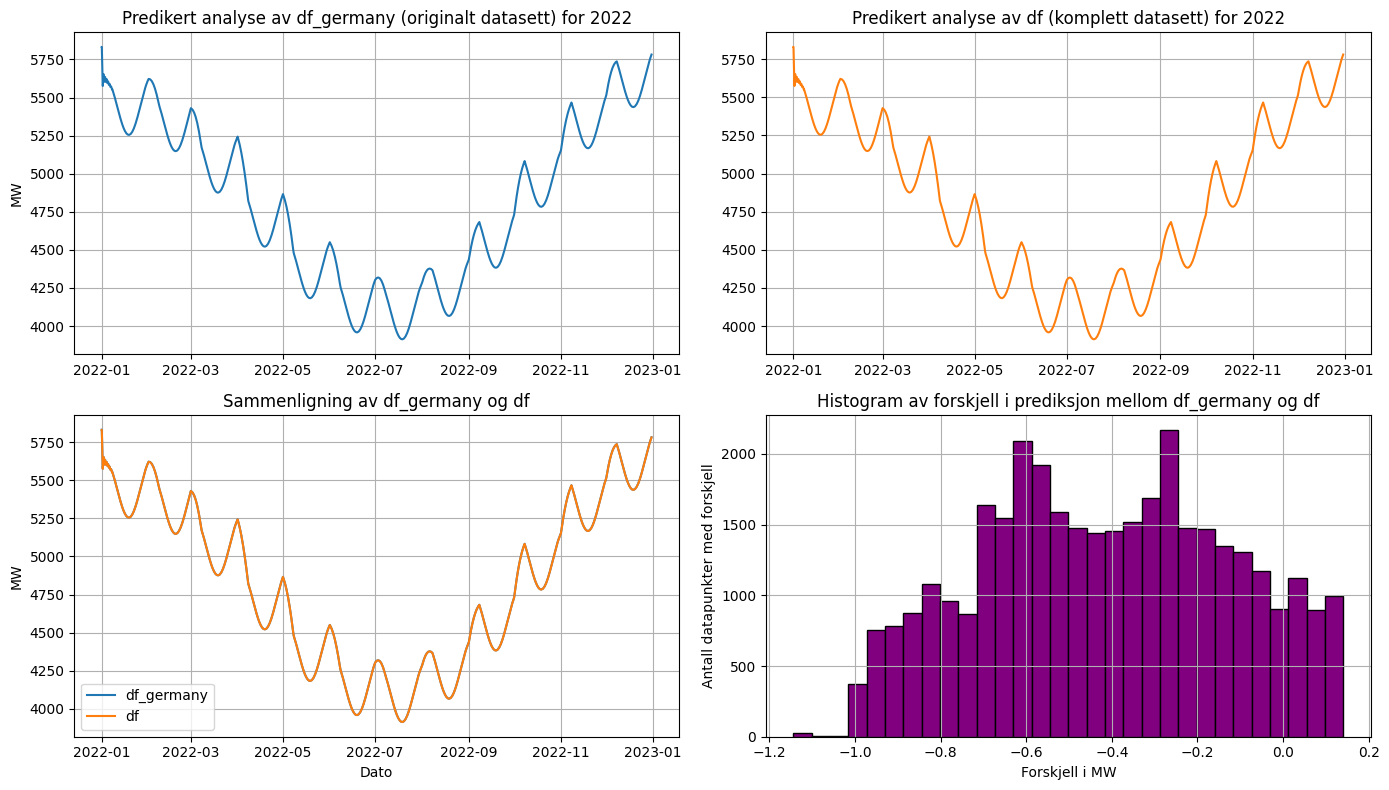

In [112]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import pandas as pd
import numpy as np
import kagglehub
import matplotlib.pyplot as plt


# Orginalt datasett (df_germany)
pathGermany = kagglehub.dataset_download("l3llff/wind-power")
df_germany = pd.read_csv(f"{pathGermany}/data.csv")
df_germany["datetime"] = pd.to_datetime(df_germany["dt"])

df_germany["hour"] = df_germany["datetime"].dt.hour
df_germany["day"] = df_germany["datetime"].dt.day
df_germany["week"] = df_germany["datetime"].dt.isocalendar().week
df_germany["month"] = df_germany["datetime"].dt.month
df_germany["year"] = df_germany["datetime"].dt.year

# Datasett etter behandling (df)
df = pd.read_csv('komplett_data_med_utfylte_mengder.csv',parse_dates=['datetime'])
df["datetime"] = pd.to_datetime(df["datetime"])

df["hour"] = df["datetime"].dt.hour
df["day"] = df["datetime"].dt.day
df["week"] = df["datetime"].dt.isocalendar().week
df["month"] = df["datetime"].dt.month
df["year"] = df["datetime"].dt.year


# Funksjon for å lage lagrede funksjoner
def lag_funksjoner(df, start_tid):
    df = df.copy()
    df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
    df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)
    df["day_sin"] = np.sin(2 * np.pi * df["day"] / 31)
    df["day_cos"] = np.cos(2 * np.pi * df["day"] / 31)
    df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
    df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)
    df["minutes_since_start"] = (df["datetime"] - start_tid).dt.total_seconds() / 60
    return df[["hour_sin", "hour_cos", "day_sin", "day_cos", "month_sin", "month_cos", "minutes_since_start"]]


start_tid = min(df["datetime"].min(), df_germany["datetime"].min())

# Lager lagrede funksjoner for df_germany og df
X_germany = lag_funksjoner(df_germany, start_tid)
y_germany = df_germany["MW"]
model_germany = LinearRegression().fit(X_germany, y_germany)

X_complete = lag_funksjoner(df, start_tid)
y_complete = df["MW"]
model_complete = LinearRegression().fit(X_complete, y_complete)

# Prediksjon for fremtidige datoer i 2022
future_dates = pd.date_range("2022-01-01", "2022-12-31 23:45", freq="15min")
future_df = pd.DataFrame({"datetime": future_dates})
future_df["hour"] = future_df["datetime"].dt.hour
future_df["day"] = future_df["datetime"].dt.day
future_df["month"] = future_df["datetime"].dt.month

# Lager lagrede funksjoner for fremtidige datoer
X_future = lag_funksjoner(future_df, start_tid)
future_df["pred_germany"] = model_germany.predict(X_future)
future_df["pred_complete"] = model_complete.predict(X_future)

# Glatter ut prediksjonene og gjørde mer lesbare
future_df["pred_germany_smooth"] = future_df["pred_germany"].rolling(window=672, min_periods=1).mean()
future_df["pred_complete_smooth"] = future_df["pred_complete"].rolling(window=672, min_periods=1).mean()



# Plotting av prediktiv analyse
plot_df = future_df[(future_df["datetime"] >= "2022-01-01") & (future_df["datetime"] <= "2022-12-31")].copy()
plot_df["forskjell"] = plot_df["pred_complete_smooth"] - plot_df["pred_germany_smooth"]

# Lager 2x2 figur
fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharex=False)

# Øverst til venstre: df_germany 
axes[0, 0].plot(plot_df["datetime"], plot_df["pred_germany_smooth"], color="tab:blue")
axes[0, 0].set_title("Predikert analyse av df_germany (originalt datasett) for 2022")
axes[0, 0].set_ylabel("MW")
axes[0, 0].grid(True)

# Øverst til høyre: df 
axes[0, 1].plot(plot_df["datetime"], plot_df["pred_complete_smooth"], color="tab:orange")
axes[0, 1].set_title("Predikert analyse av df (komplett datasett) for 2022")
axes[0, 1].grid(True)

# Nederst til venstre: Sammenligning av df_germany og df
axes[1, 0].plot(plot_df["datetime"], plot_df["pred_germany_smooth"], label="df_germany", color="tab:blue")
axes[1, 0].plot(plot_df["datetime"], plot_df["pred_complete_smooth"], label="df", color="tab:orange")
axes[1, 0].set_title("Sammenligning av df_germany og df")
axes[1, 0].set_xlabel("Dato")
axes[1, 0].set_ylabel("MW")
axes[1, 0].legend()
axes[1, 0].grid(True)

# Nederst til høyre: Histogram av forskjell mellom df_germany og df
axes[1, 1].hist(plot_df["forskjell"], bins=30, color="purple", edgecolor="black")
axes[1, 1].set_title("Histogram av forskjell i prediksjon mellom df_germany og df")
axes[1, 1].set_xlabel("Forskjell i MW")
axes[1, 1].set_ylabel("Antall datapunkter med forskjell")
axes[1, 1].grid(True)

# Viser figuren
plt.tight_layout()
plt.show()

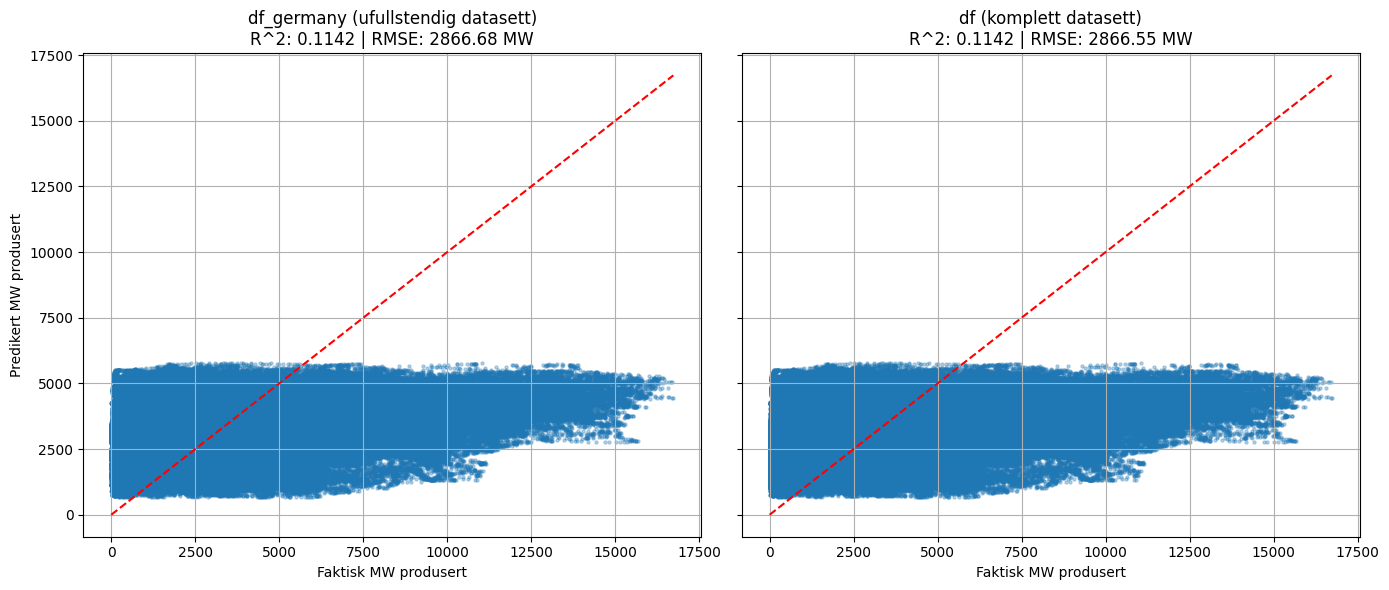

In [113]:
# Sammenligning av prediksjonene for df og df_germany
y_pred_df = model_complete.predict(X_complete)
y_pred_germany = model_germany.predict(X_germany)

# R^2 og RMSE for df og df_germany
r2_df = r2_score(y_complete, y_pred_df)
rmse_df = np.sqrt(mean_squared_error(y_complete, y_pred_df))

r2_germany = r2_score(y_germany, y_pred_germany)
rmse_germany = np.sqrt(mean_squared_error(y_germany, y_pred_germany))

# Scatterplots ved siden av hverandre
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

# df_germany
axes[0].scatter(y_germany, y_pred_germany, alpha=0.3, s=5)
axes[0].plot([y_germany.min(), y_germany.max()], [y_germany.min(), y_germany.max()], 'r--')
axes[0].set_title(f"df_germany (ufullstendig datasett)\nR^2: {r2_germany:.4f} | RMSE: {rmse_germany:.2f} MW")
axes[0].set_xlabel("Faktisk MW produsert")
axes[0].set_ylabel("Predikert MW produsert")
axes[0].grid(True)

# df 
axes[1].scatter(y_complete, y_pred_df, alpha=0.3, s=5)
axes[1].plot([y_complete.min(), y_complete.max()], [y_complete.min(), y_complete.max()], 'r--')
axes[1].set_title(f"df (komplett datasett)\nR^2: {r2_df:.4f} | RMSE: {rmse_df:.2f} MW")
axes[1].set_xlabel("Faktisk MW produsert")
axes[1].grid(True)

plt.tight_layout()
plt.show()